<a href='https://www.valassis.com/'><img src='images/ValassisDigital_WebLogo.jpg' width="500" height="400"/></a>

# <center> Valassis Digital Interview Assessment <center/>

### Table of Contents

1. <a href="#1.-Problem-Description">Problem Description</a>
2. <a href="#2.-Data-Preparation-and-EDA">Data Preparation and EDA</a>
3. <a href="#3.-A/B-Testing-and-Hypothesis-Statements">A/B Testing and Hypothesis Statements</a>
4. <a href="#4.-Retargeting">Retargeting</a>
5. <a href="#4.-Conclusion">Conclusion</a>

-------------

### 1. Problem Description
`Valassis Digital` has run a digital advertising campaign for one of our clients, targeting mobile users in the Southeast. The goal of the campaign was to `drive conversions` -- users clicking through the ad and accepting our client's offer. To execute this campaign, we built an audience of target users based on historical information about the likelihood to convert.

Our campaigns are executed on real-time bidding (RTB) exchanges. Web pages or mobile apps submit bid requests to potential advertisers on these exchanges. If Valassis Digital sees a bid request for a user we want to target on a web page or mobile app we want to serve on, we will submit a bid for that advertising placement. If we submit the highest (or only) bid, we win the placement and serve an ad. Given that we have won and served the ad, a user then has the opportunity to convert.

We'd like you to take a look at the campaign's results to answer two primary questions:

<div class="alert alert-info" >

1.	We ran two creatives (distinct ad designs) during the campaign: a baseline creative in line with our client's previous campaigns, and a new creative designed to increase conversions by more prominently displaying the offer to the user.  To do this, we assigned some users to a "test" group that received the new ad during the campaign.  Did the new creative increase conversions?
2.	We are equally likely to bid on any user at any time during a campaign.  Other advertisers have found success by "retargeting" users -- increasing the likelihood of a bid for users that have previously landed on a page or actually converted in the past (e.g. redeeming a digital coupon). Would retargeting have improved performance for this campaign?
    
</div>


-------------

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import re
import json
import statsmodels.api as sm
from scipy import stats
from src import plot
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 2. Data Preparation and EDA

In [2]:
# read data into a dataframe
users = pd.read_csv('data/user_attributes.csv')
bid_request = pd.read_csv('data/bid_requests.csv')

In [3]:
# check the head of the users data
users.head()

,user_id,attributes
0,00003e3b9e5336685200ae85d21b4f5e,"{""age"": 33, ""gender"": ""F"", ""location"": ""FL"", ""..."
1,000053b1e684c9e7ea73727b2238ce18,"{""age"": 26, ""gender"": ""M"", ""location"": ""AL"", ""..."
2,00029153d12ae1c9abe59c17ff2e0895,"{""age"": 29, ""gender"": ""F"", ""location"": ""AR"", ""..."
3,0002ac0d783338cfeab0b2bdbd872cda,"{""age"": 29, ""gender"": ""M"", ""location"": ""SC"", ""..."
4,0004d0b59e19461ff126e3a08a814c33,"{""age"": 27, ""gender"": ""F"", ""location"": ""AR"", ""..."


In [4]:
# check the head of the bid_request data
bid_request.head()

,timestamp,user_id,bid,win,conversion
0,2017-01-01 00:00:01,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0
1,2017-01-01 00:00:02,26c5dca2512a4c7fe8810bd04191b1b3,0,0,0
2,2017-01-01 00:00:05,2121376a323507c01c5e92c39ae8ccd4,0,0,0
3,2017-01-01 00:00:12,fa6a0925d911185338b0acc93c66dc92,0,0,0
4,2017-01-01 00:00:13,4299f209da83da82b711f1d631cc607b,1,0,0


In [5]:
# check for the data types of the user data
users.dtypes

user_id       object
attributes    object
dtype: object

In [6]:
# check for the data types of the bid_request data
bid_request.dtypes

timestamp     object
user_id       object
bid            int64
win            int64
conversion     int64
dtype: object

In [7]:
# shape of the data to see the number of features and rows - users
users.shape

(100000, 2)

In [8]:
# shape of the data to see the number of features and rows - bid_request
bid_request.shape

(600000, 5)

`json_normalize` does not work here because values in dictionary are object data type. Hence, we extract the columns of age, gender, location, and test out of the attributes column using the string accessor method of pandas with the help of regular expression. `json.loads` also work here for the same task.

In [9]:
# users['age'] = users['attributes'].str.extract((r'(\d+)'))
# users['gender'] = users['attributes'].str.extract(r'(M|F)')
# users['location'] = users['attributes'].str.extract(r'([A-Z]{2})')
# users['test'] = users['attributes'].str.extract(r'(0|1){1}')
# users.drop('attributes', axis=1, inplace=True)

In [10]:
# define a function to convert and extract the relevant features out of the attributes column
def convert_dict(x):
    return json.loads(x)

In [11]:
# apply convert_dict function above to the attributes feature of the users' data
users.attributes = users.attributes.apply(convert_dict)

In [12]:
users[['age','gender','location','test']] = pd.DataFrame(users.attributes.tolist())[['age','gender','location','test']]
users = users.drop('attributes',axis=1)

In [13]:
# confirm that age, gender, location, and test features are now separate
users.head()

,user_id,age,gender,location,test
0,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1
1,000053b1e684c9e7ea73727b2238ce18,26,M,AL,1
2,00029153d12ae1c9abe59c17ff2e0895,29,F,AR,1
3,0002ac0d783338cfeab0b2bdbd872cda,29,M,SC,0
4,0004d0b59e19461ff126e3a08a814c33,27,F,AR,1


Here, we need to convert the timestamp feature's data type from object to datetime, because we may need it to sort out the data later.

In [14]:
# convert the timestamp feature's data type to datetime object 
bid_request['timestamp'] = pd.to_datetime(bid_request['timestamp'])

In [15]:
# again, check the head of the bid_request data to confirm the changes 
bid_request.head()

,timestamp,user_id,bid,win,conversion
0,2017-01-01 00:00:01,be7485be5b6eb3690efcbc9e95e8f15a,0,0,0
1,2017-01-01 00:00:02,26c5dca2512a4c7fe8810bd04191b1b3,0,0,0
2,2017-01-01 00:00:05,2121376a323507c01c5e92c39ae8ccd4,0,0,0
3,2017-01-01 00:00:12,fa6a0925d911185338b0acc93c66dc92,0,0,0
4,2017-01-01 00:00:13,4299f209da83da82b711f1d631cc607b,1,0,0


Here, I wanted to see the number of unique users in the users and bid_request datasets. As can be seen, all the users in the users dataset are unique, while the bid_request dataset only has 63,137 unique users.

In [16]:
print('Number of unique users in users data:', users['user_id'].nunique())
print('Number of unique users in bid_request data:', bid_request['user_id'].nunique())

Number of unique users in users data: 100000
Number of unique users in bid_request data: 63137


The goal of this task is to find out if the change in ad design actually works or not to increase the conversion rate. To do so, we have a baseline group or control group where no changes made to the ad design and a test group where changes were made to the ad design. To have a meaningful results of this test, we need to check for the number of users assigned in each of control and test groups. As the following output shows, the number of users in the control group is `43,916` while it is `56,084` in the test group. The users were almost equally splitted into the control and test groups.

In [17]:
users['test'].value_counts()

1    56084
0    43916
Name: test, dtype: int64

Another sanity check is to look at the distribution of users in each group regarding the number of males and females, average, minimum, and maximum age, and count of the users in each location. Based on the output below, we can say that the control and test groups show similar characteristics which is good to have for better comparisons.

In [18]:
users.groupby(['test', 'gender', 'location'])['age'].agg(['mean', 'count', 'min', 'max'])

mean  count  min  max
test gender location                            
0    F      AL        25.692799   1097   18   33
            AR        25.410357   2549   18   33
            FL        25.455870   2470   18   33
            GA        25.614724   2445   18   33
            KY        25.355388   2524   18   33
            LA        25.408147   2455   18   33
            MS        25.643872   1126   18   33
            NC        25.471959   1159   18   33
            SC        25.524736   2466   18   33
            TN        25.598361   1098   18   33
            VA        25.363561   2426   18   33
     M      AL        25.575809   1174   18   33
            AR        25.531840   2544   18   33
            FL        25.465846   2518   18   33
            GA        25.411458   2496   18   33
            KY        25.472853   2468   18   33
            LA        25.552535   2465   18   33
            MS        25.339858   1124   18   33
            NC        25.897758   1115   18   33
            SC        25.463633   2571   18   33
            TN        25.472811   1085   18   33
            VA        25.457300   2541   18   33
1    F      AL        25.435756   3440   18   33
            AR        25.401659   2049   18   33
            FL        25.303204   2091   18   33
            GA        25.464147   2064   18   33
            KY        25.438670   2136   18   33
            LA        25.548817   2028   18   33
            MS        25.529672   3387   18   33
            NC        25.512760   3409   18   33
            SC        25.404809   2038   18   33
            TN        25.647522   3430   18   33
            VA        25.551081   2036   18   33
     M      AL        25.508777   3418   18   33
            AR        25.471122   2095   18   33
            FL        25.535135   2035   18   33
            GA        25.505085   2065   18   33
            KY        25.376514   2146   18   33
            LA        25.496735   1991   18   33
            MS        25.722533   3395   18   33
            NC        25.434421   3370   18   33
            SC        25.382150   2028   18   33
            TN        25.413854   3378   18   33
            VA        25.621411   2055   18   33

Now, we need to merge these two datasets on user_id using the following code.

In [19]:
# merge the users and bid_request datasets on user_id
df = users.merge(bid_request, on=['user_id'])

In [20]:
# check for the head of the merged data: df
df.head()

,user_id,age,gender,location,test,timestamp,bid,win,conversion
0,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-01 13:43:34,1,0,0
1,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-04 03:59:18,0,0,0
2,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-04 17:41:50,1,1,0
3,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-07 04:02:42,1,1,0
4,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-08 09:05:01,1,0,0


In [21]:
df.shape

(600000, 9)

The merged dataset now have 9 features and 600,000 rows/observations.

To have a better insight into the merged data, let's look at the following two outputs. They show the number of bid request for two separate users. As can be seen, while 10 bid requests were made for the first user, 32 bid requests were made for the second user below. Another important distinction between these two particular users is that the first user was never converted out of the 4 bids won, while the second user was converted 5 times out of 17 bids won. These two instances also help us retargeting concept.

In [22]:
df[df.user_id == '00003e3b9e5336685200ae85d21b4f5e'].sort_values('timestamp')

,user_id,age,gender,location,test,timestamp,bid,win,conversion
0,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-01 13:43:34,1,0,0
1,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-04 03:59:18,0,0,0
2,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-04 17:41:50,1,1,0
3,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-07 04:02:42,1,1,0
4,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-08 09:05:01,1,0,0
5,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-10 23:02:32,1,0,0
6,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-13 06:21:40,0,0,0
7,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-13 22:40:11,0,0,0
8,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-15 09:46:48,1,1,0
9,00003e3b9e5336685200ae85d21b4f5e,33,F,FL,1,2017-01-17 02:53:55,1,1,0


In [23]:
df[df.user_id == 'e879bd196b9b3e4db974b8716c6f896e'].sort_values('timestamp')

,user_id,age,gender,location,test,timestamp,bid,win,conversion
544921,e879bd196b9b3e4db974b8716c6f896e,26,F,VA,0,2017-01-01 06:42:33,1,1,0
544922,e879bd196b9b3e4db974b8716c6f896e,26,F,VA,0,2017-01-01 18:34:53,1,1,0
544923,e879bd196b9b3e4db974b8716c6f896e,26,F,VA,0,2017-01-02 04:26:34,1,0,0
544924,e879bd196b9b3e4db974b8716c6f896e,26,F,VA,0,2017-01-02 11:01:28,0,0,0
544925,e879bd196b9b3e4db974b8716c6f896e,26,F,VA,0,2017-01-05 00:36:39,0,0,0
544926,e879bd196b9b3e4db974b8716c6f896e,26,F,VA,0,2017-01-05 03:04:36,1,1,0
544927,e879bd196b9b3e4db974b8716c6f896e,26,F,VA,0,2017-01-05 12:09:34,1,1,0
544928,e879bd196b9b3e4db974b8716c6f896e,26,F,VA,0,2017-01-07 04:46:22,1,0,0
544929,e879bd196b9b3e4db974b8716c6f896e,26,F,VA,0,2017-01-07 11:15:04,1,1,0
544930,e879bd196b9b3e4db974b8716c6f896e,26,F,VA,0,2017-01-07 15:55:34,1,1,0


One last time, let's see the distribution of bid requests for males and females for the control and test groups. Again, almost equal number of bid requests were made for males and females in both of the control and test groups.

In [24]:
df.groupby(['test', 'gender'])['bid'].agg(['count', 'mean'])

count      mean
test gender                  
0    F       130773  0.498826
     M       131334  0.500723
1    F       169101  0.498507
     M       168792  0.500901

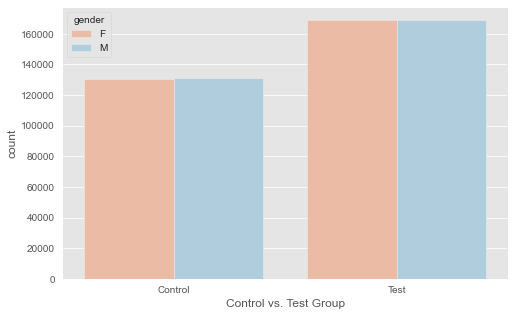

In [25]:
# explore the distribution of males and females in the control and test groups
plt.figure(figsize=(8,5))
sns.countplot(x='test', hue='gender', data=df, palette='RdBu')
plt.xlabel('Control vs. Test Group')
plt.xticks([0,1], ['Control', 'Test'])
plt.show()

------------------------

### 3. A/B Testing and Hypothesis Statements

`Baseline (Control Group (A))`: Creative in line with our client's previous campaigns <br>
`Test Group (B)`: A new creative designed to increase conversions by more prominently displaying the offer to the user

$H_{0}$: The change in ad design would result in no change in the conversion rate <br>
$H_{1}$: The change in ad design would result in an improvement in the conversion rate

----------------

#### - Number of Bid Requests in the Control and Test Groups

In [26]:
# find out the number of bid requests in the test and control groups
df['test'].value_counts()

1    337893
0    262107
Name: test, dtype: int64

The baseline/control group (A) has 262,107 bid request while the test group (B) has 337,893 bid request.

#### - Number of Unique Users

The merged dataset has not all the users from the users dataset. Since we performed an inner join between users and bid_request datasets, the final dataset of df involves only the users that exist in both the datasets which corresponds to 63,137 (it is the number of unique users in the bid_request dataset). I also want to see how the users were splitted between the control and test groups in the merged dataframe of df. The following ouput indicates that while the control group has a total of 27,608 unique users, the test group has a total of 35,529 unique users. 

In [27]:
df.groupby('test')['user_id'].nunique()

test
0    27608
1    35529
Name: user_id, dtype: int64

#### - Average Number of Bid Requests in Each Group

The average number of bid requests per user in each group were checked using the following codes. An average of `9.49 bid requests` were made for the users in the control group, while an average of `9.51 bid requests` were made for the users in the test group. 

In [28]:
print('Average number of bid requests per user in the test group:', 337893/35529)
print('Average number of bid requests per user in the control group:', 262107/27608)

Average number of bid requests per user in the test group: 9.510343662923246
Average number of bid requests per user in the control group: 9.493878585917125


#### - Number of Bids Won in Each Group

In [29]:
df[(df.test == 1)&(df.bid ==1)].win.value_counts()

1    84595
0    84251
Name: win, dtype: int64

A total of `84,595` bids were won in the test group with 337,893 bid requests.

In [30]:
df[(df.test == 0)&(df.bid ==1)].win.value_counts()

1    65564
0    65431
Name: win, dtype: int64

A total of `65,564` bids were won in the control group with 262,107 bid requests.

#### - Conversion Rate

In [31]:
df[(df.test == 1)&(df.win == 1)].conversion.value_counts()

0    81203
1     3392
Name: conversion, dtype: int64

Out of 84,595 bid wins in the test group, `3,392` times the users were converted. Please note that, some users were converted more than once. 

In [32]:
df[(df.test == 0)&(df.win == 1)].conversion.value_counts()

0    62841
1     2723
Name: conversion, dtype: int64

2,723 users were converted out of 65,564 users in the baseline/control group.

In [33]:
# check the users with the highest number of conversions
df.groupby('user_id')['conversion'].sum().reset_index().sort_values(by='conversion', ascending=False).head()

,user_id,conversion
57306,e879bd196b9b3e4db974b8716c6f896e,5
20985,54f07ff91a4441b2de263b955ab8a6a0,5
36764,9570efef719d705326f0ff817ef084e6,4
58191,ec151b6ecbb40275f4ac68bc99635554,3
3643,0e4c11f657de720a1b7aeb04e2ba810e,3


In [34]:
bcr = 2723/65564 #----> baseline conversion rate (control group)
print('Conversion rate for the baseline/control group is', bcr)

Conversion rate for the baseline/control group is 0.04153193825880056


In [35]:
tcr = 3392/84595 #----> test group conversion rate (test group)
print('Conversion rate for the test group is', tcr)

Conversion rate for the test group is 0.04009693244281577


In [36]:
# difference between the conversion rates of the control and test groups
d_hat = tcr - bcr

# sample size for the control and test groups
N_A = df[(df.test == 0)&(df.win == 1)].win.sum()
N_B = df[(df.test == 1)&(df.win == 1)].win.sum()

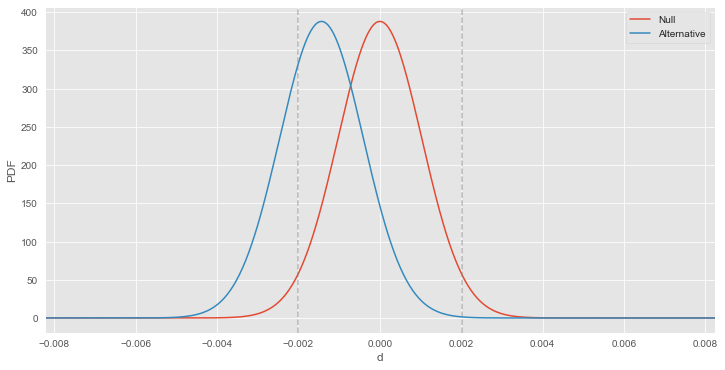

In [37]:
# compare the two groups --- Binomial distribution as the conversion rate is a discrete binary metric
plot.abplot(N_A, N_B, bcr, d_hat, show_power=False)

#### -Two-sample T-test

Theoretically, t-test is only for continous data because discrete can never meet the normality assumption. However, t-test is quite robust given enough samples due to Central Limit Theory.

In [38]:
a = df[(df.test == 0)&(df.win == 1)].conversion
b = df[(df.test == 1)&(df.win == 1)].conversion

In [39]:
t, p_val = stats.ttest_ind(a, b, equal_var = True)
print(t, p_val)

1.395367229963658 0.1629071915461419


The p value out of the t-test is greater than 0.05 (p>0.05). Therefore, we fail to reject the null hypothesis. It means that there no difference between the control and test groups and the change in the ad design makes no improvement in the conversion rate.

#### - Logistic Regression

In [40]:
# exract the dataframe where win=1
df_won = df[df.win==1]

In [41]:
df_won = df_won.sample(n=1000) # logistic regression is biased toward larger sample size

In [42]:
# extract the following features from the timestamp variable to be used in the model
df_won['hour'] = df_won.timestamp.dt.hour
df_won['day'] = df_won.timestamp.dt.day
df_won['week'] = df_won.timestamp.dt.week
df_won['dayofweek'] = df_won.timestamp.dt.dayofweek

In [43]:
# recode the gender variable as M=1 and F=0
df_won['gender'].replace({'M':1, 'F':0}, inplace=True)

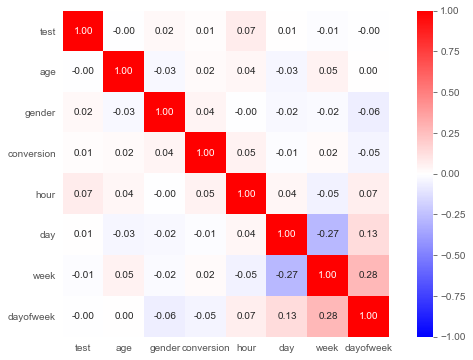

In [44]:
# plot a heatmap based on the correlation values between the features
plt.figure(figsize=(10,6))
sns.heatmap(df_won[['test', 'age', 'gender', 'conversion', 'hour', 'day', 'week', 'dayofweek']].corr(), 
            vmin=-1, vmax=1,square=True, annot=True, cmap='bwr', cbar=True, fmt=".2f")
plt.show()

In [45]:
# extract the features/independent variables and the target/dependent variable
X = df_won[['test', 'age', 'gender', 'hour', 'day', 'week', 'dayofweek']]
y = df_won['conversion']

In [46]:
# fit it to the data and print the summary of the model
sm.Logit(y, X).fit().summary()

Optimization terminated successfully.
         Current function value: 0.148649
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             conversion   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      993
Method:                           MLE   Df Model:                            6
Date:                Thu, 24 Sep 2020   Pseudo R-squ.:                -0.02502
Time:                        10:56:34   Log-Likelihood:                -148.65
converged:                       True   LL-Null:                       -145.02
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
test          -0.1279      0.341     -0.375      0.708      -0.797       0.541
age           -0.1099      0.019     -5.843      0.000      -0.147      -0.073
gender         0.1532      0.337      0.455      0.649      -0.507       0.814
hour           0.0246      0.024      1.032      0.302      -0.022       0.071
day           -0.0305      0.027     -1.126      0.260      -0.084       0.023
week           0.0180      0.018      1.012      0.311      -0.017       0.053
dayofweek     -0.2162      0.093     -2.323      0.020      -0.399      -0.034
==============================================================================
"""

### 4. Retargeting

In [59]:
(df.groupby('user_id').conversion.sum() > 0).mean()

0.08880688027622471

The percentage of users who were converted at least once or more is about 9%.

In [60]:
(df[(df.conversion == 1)].groupby('user_id').conversion.count() > 1).mean()

0.08257535223827359

The percantage of users who were converted more than 1 is about 8% of the users converted at least once.

In [49]:
0.08880688027622471 * 0.08257535223827359

0.007333259419991447

### 5. Conclusion

Overall, the change in ad design (the new creative designed to increase conversions by more prominently displaying the offer to the user) would make no difference in the conversion rates. Retargeting has also a very small improvement on the performance of this campaign. On average, 9% of the bid requests tend to be converted. Retargeting would only make a 0.7% difference on the conversion rates. 

<a href="#Table-of-Contents">Back to Top</a> <br>